In [1]:
# train_rgb_only_fasterrcnn.py

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# ─── Data loading utilities ────────────────────────────────────────────────────

def load_rgb(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    assert img is not None, f"Failed to load {path}"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0  # H×W×3

def parse_yolo_labels(path: Path, img_shape: tuple) -> torch.Tensor:
    H, W = img_shape
    boxes = []
    if path.exists():
        with open(path, 'r') as f:
            for line in f:
                cls, xc, yc, w, h = map(float, line.split())
                x0 = (xc - w/2) * W;  y0 = (yc - h/2) * H
                x1 = (xc + w/2) * W;  y1 = (yc + h/2) * H
                boxes.append([x0, y0, x1, y1, int(cls)])
    if boxes:
        return torch.tensor(boxes, dtype=torch.float32)
    return torch.zeros((0,5), dtype=torch.float32)

def collate_fn(batch):
    return tuple(zip(*batch))


# ─── RGB-Only Dataset ──────────────────────────────────────────────────────────

class RGBDataset(Dataset):
    def __init__(self, root: str):
        root = Path(root)
        self.rgb_files = sorted((root/"rgb").glob("*.jpg"))
        assert self.rgb_files, f"No RGB images in {root/'rgb'}"

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = self.rgb_files[idx]
        stem     = rgb_path.stem
        label_path = rgb_path.parent.parent/"labels"/f"{stem}.txt"

        rgb = load_rgb(rgb_path)                # H×W×3
        boxes = parse_yolo_labels(label_path, rgb.shape[:2])  # N×5

        # to tensor C×H×W
        img_t = torch.from_numpy(rgb.transpose(2,0,1))  # 3×H×W

        # shift labels +1 so 0 is background
        target = {
            "boxes":  boxes[:, :4],
            "labels": boxes[:, 4].long() + 1
        }
        return img_t, target


# ─── Model Factory ─────────────────────────────────────────────────────────────

def get_fasterrcnn_rgb(num_classes: int):
    # load a standard 3-channel pretrained FPN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # replace the box predictor
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model


# ─── Training & Early Stopping ─────────────────────────────────────────────────

def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch} [train]", unit="batch")
    total_loss = 0.0
    for imgs, targets in pbar:
        imgs = [img.to(device) for img in imgs]
        tgts = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, tgts)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(train_loss=f"{loss.item():.4f}")
    pbar.close()
    return total_loss / len(loader)

@torch.no_grad()
def eval_loss(model, loader, device):
    model.train()  # to get loss keys
    pbar = tqdm(loader, desc="[val]  ", unit="batch")
    total_loss = 0.0
    for imgs, targets in pbar:
        imgs = [img.to(device) for img in imgs]
        tgts = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, tgts)
        loss = sum(loss for loss in loss_dict.values())
        total_loss += loss.item()
        pbar.set_postfix(val_loss=f"{loss.item():.4f}")
    pbar.close()
    return total_loss / len(loader)


if __name__ == "__main__":
    # ── Hyperparameters ─────────────────────────────────────────────────────────
    ROOT_DIR    = "Processed_data"
    NUM_CLASSES = 6 + 1   # 6 object classes + background
    BATCH_SIZE  = 8
    LR          = 1e-4
    WD          = 1e-4
    MAX_EPOCHS  = 20
    PATIENCE    = 5
    VAL_SPLIT   = 0.2
    SEED        = 42
    DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # ──────────────────────────────────────────────────────────────────────────────

    # dataset & split
    ds = RGBDataset(ROOT_DIR)
    n_val = int(len(ds) * VAL_SPLIT)
    train_ds, val_ds = random_split(
        ds, [len(ds)-n_val, n_val],
        generator=torch.Generator().manual_seed(SEED)
    )

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, collate_fn=collate_fn
    )

    # model & optimizer
    model = get_fasterrcnn_rgb(NUM_CLASSES).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    best_val = float("inf")
    epochs_no_improve = 0

    for epoch in range(1, MAX_EPOCHS+1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, DEVICE, epoch)
        vl_loss = eval_loss(model, val_loader, DEVICE)

        print(f"Epoch {epoch:02d} — train_loss: {tr_loss:.4f}, val_loss: {vl_loss:.4f}")

        if vl_loss < best_val:
            best_val = vl_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "rgb_only_best.pth")
            print("  ↳ New best! Model saved.")
        else:
            epochs_no_improve += 1
            print(f"  ↳ No improvement for {epochs_no_improve}/{PATIENCE} epochs.")
            if epochs_no_improve >= PATIENCE:
                print("Early stopping triggered. Ending training.")
                break

    print("Training complete. Best val_loss:", best_val)


f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.53batch/s, val_loss=0.1307]


Epoch 01 — train_loss: 0.1901, val_loss: 0.0990
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.62batch/s, val_loss=0.0682]


Epoch 02 — train_loss: 0.0725, val_loss: 0.0661
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.63batch/s, val_loss=0.0431]


Epoch 03 — train_loss: 0.0546, val_loss: 0.0544
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.77batch/s, val_loss=0.0403]


Epoch 04 — train_loss: 0.0396, val_loss: 0.0464
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.56batch/s, val_loss=0.0412]


Epoch 05 — train_loss: 0.0372, val_loss: 0.0476
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.58batch/s, val_loss=0.0338]


Epoch 06 — train_loss: 0.0336, val_loss: 0.0459
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.54batch/s, val_loss=0.0332]


Epoch 07 — train_loss: 0.0320, val_loss: 0.0427
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.70batch/s, val_loss=0.0303]


Epoch 08 — train_loss: 0.0305, val_loss: 0.0387
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.42batch/s, val_loss=0.0483]


Epoch 09 — train_loss: 0.0254, val_loss: 0.0414
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.53batch/s, val_loss=0.0383]


Epoch 10 — train_loss: 0.0261, val_loss: 0.0446
  ↳ No improvement for 2/5 epochs.


[val]  : 100%|██████████| 33/33 [00:05<00:00,  5.88batch/s, val_loss=0.0254]


Epoch 11 — train_loss: 0.0244, val_loss: 0.0349
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.30batch/s, val_loss=0.0226]


Epoch 12 — train_loss: 0.0204, val_loss: 0.0337
  ↳ New best! Model saved.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.62batch/s, val_loss=0.0262]


Epoch 13 — train_loss: 0.0218, val_loss: 0.0375
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.53batch/s, val_loss=0.0472]


Epoch 14 — train_loss: 0.0290, val_loss: 0.0497
  ↳ No improvement for 2/5 epochs.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.65batch/s, val_loss=0.0332]


Epoch 15 — train_loss: 0.0327, val_loss: 0.0421
  ↳ No improvement for 3/5 epochs.


[val]  : 100%|██████████| 33/33 [00:04<00:00,  7.56batch/s, val_loss=0.0267]


Epoch 16 — train_loss: 0.0224, val_loss: 0.0370
  ↳ No improvement for 4/5 epochs.


[val]  : 100%|██████████| 33/33 [00:05<00:00,  6.00batch/s, val_loss=0.0248]

Epoch 17 — train_loss: 0.0194, val_loss: 0.0359
  ↳ No improvement for 5/5 epochs.
Early stopping triggered. Ending training.
Training complete. Best val_loss: 0.03372754052168492


f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating: 100%|██████████| 66/66 [00:03<00:00, 17.28it/s]



RGB-only detection accuracy (IoU≥0.5): 97.27%



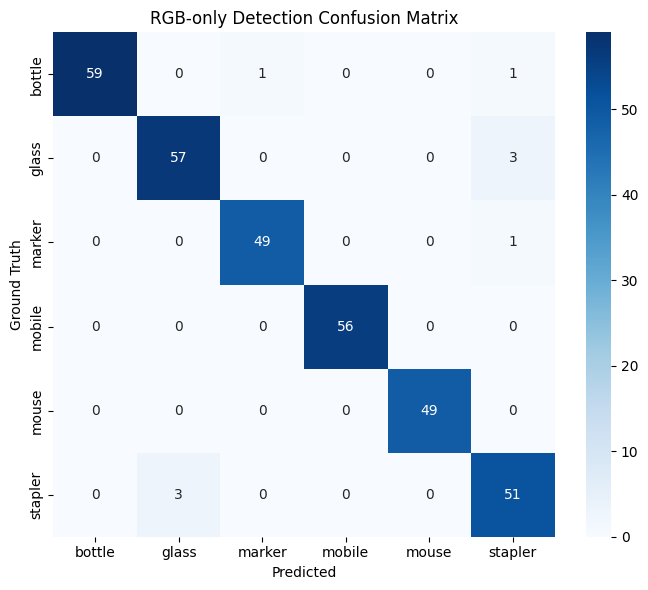

In [2]:
# evaluate_rgb_only.py

import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

# from train_rgb_only_fasterrcnn import (
#     get_fasterrcnn_rgb,
#     RGBDataset,
#     collate_fn
# )

def compute_iou(a, b):
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (a[2]-a[0])*(a[3]-a[1])
    areaB = (b[2]-b[0])*(b[3]-b[1])
    uni = areaA + areaB - inter
    return inter/uni if uni>0 else 0.0

def evaluate(model, loader, device,
             iou_thresh=0.5, score_thresh=0.5, label_map=None):
    gt_list, pred_list = [], []
    model.eval()
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Evaluating"):
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)
            for out, tgt in zip(outputs, targets):
                gt_boxes  = tgt["boxes"].cpu().numpy()
                gt_labels = tgt["labels"].cpu().numpy()
                pb = out["boxes"].cpu().numpy()
                pl = out["labels"].cpu().numpy()
                ps = out["scores"].cpu().numpy()
                keep = ps >= score_thresh
                pb, pl = pb[keep], pl[keep]
                if len(gt_boxes)==0 or len(pb)==0:
                    continue
                for gbox, glab in zip(gt_boxes, gt_labels):
                    ious = np.array([compute_iou(gbox, p) for p in pb])
                    j = ious.argmax()
                    if ious[j] >= iou_thresh:
                        gt_list.append(int(glab))
                        pred_list.append(int(pl[j]))

    # overall accuracy
    acc = accuracy_score(gt_list, pred_list)
    print(f"\nRGB-only detection accuracy (IoU≥{iou_thresh}): {acc*100:.2f}%\n")

    # confusion matrix
    classes = sorted(label_map.keys())
    names   = [label_map[c] for c in classes]
    cm = confusion_matrix(gt_list, pred_list, labels=classes)

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=names, yticklabels=names)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.title("RGB-only Detection Confusion Matrix")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ROOT_DIR  = "Processed_data"
    WEIGHTS   = "rgb_only_best.pth"
    LABEL_MAP = {
        1: "bottle",
        2: "glass",
        3: "marker",
        4: "mobile",
        5: "mouse",
        6: "stapler"
    }

    # build & load
    model = get_fasterrcnn_rgb(num_classes=len(LABEL_MAP)+1)
    state = torch.load(WEIGHTS, map_location=DEVICE)
    model.load_state_dict(state)
    model.to(DEVICE)

    # val loader
    ds    = RGBDataset(ROOT_DIR)
    n_val = int(len(ds) * 0.2)
    _, val_ds = random_split(
        ds, [len(ds)-n_val, n_val],
        generator=torch.Generator().manual_seed(42)
    )
    val_loader = DataLoader(
        val_ds, batch_size=4, shuffle=False,
        num_workers=0, collate_fn=collate_fn
    )

    evaluate(
        model, val_loader, DEVICE,
        iou_thresh=0.5, score_thresh=0.5,
        label_map=LABEL_MAP
    )


In [3]:
import torch
import cv2
import numpy as np
from pathlib import Path
# from train_rgb_only_fasterrcnn import get_fasterrcnn_rgb

# ─── CONFIG ────────────────────────────────────────────────────────────────────
IMAGE_PATH = "Processed_data/rgb/20250718_122755_172682.jpg"
WEIGHTS    = "rgb_only_best.pth"
SCORE_THR  = 0.5
LABEL_MAP  = {
    1: "bottle",
    2: "glass",
    3: "marker",
    4: "mobile",
    5: "mouse",
    6: "stapler"
}
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ───────────────────────────────────────────────────────────────────────────────

# Build model & load weights
model = get_fasterrcnn_rgb(num_classes=len(LABEL_MAP) + 1)
state = torch.load(WEIGHTS, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE).eval()

# Load image
img_bgr = cv2.imread(IMAGE_PATH)
assert img_bgr is not None, f"Failed to load {IMAGE_PATH}"
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

# To tensor (C×H×W)
inp = torch.from_numpy(img_rgb.transpose(2,0,1)).to(DEVICE)

# Inference
with torch.no_grad():
    output = model([inp])[0]

# Draw predictions
for box, score, cid in zip(output["boxes"], output["scores"], output["labels"]):
    if score < SCORE_THR or cid == 0:
        continue
    x0,y0,x1,y1 = map(int, box.tolist())
    name = LABEL_MAP[int(cid)]
    cv2.rectangle(img_bgr, (x0,y0), (x1,y1), (0,255,0), 2)
    cv2.putText(img_bgr, f"{name}:{score:.2f}", (x0,y0-6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Show
cv2.imshow("RGB-Only Inference", img_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()


f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import torch
import cv2
import numpy as np
# from train_rgb_only_fasterrcnn import get_fasterrcnn_rgb

# ─── CONFIG ────────────────────────────────────────────────────────────────────
WEIGHTS   = "rgb_only_best.pth"
SCORE_THR = 0.5
LABEL_MAP = {
    1: "bottle",
    2: "glass",
    3: "marker",
    4: "mobile",
    5: "mouse",
    6: "stapler"
}
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ───────────────────────────────────────────────────────────────────────────────

# Build model & load weights
model = get_fasterrcnn_rgb(num_classes=len(LABEL_MAP) + 1)
state = torch.load(WEIGHTS, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE).eval()

# Open first webcam
cap = cv2.VideoCapture(0)
assert cap.isOpened(), "Cannot open webcam"

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # BGR→RGB, normalize
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        inp     = torch.from_numpy(img_rgb.transpose(2,0,1)).to(DEVICE)

        # Inference
        with torch.no_grad():
            out = model([inp])[0]

        # Draw
        for box, score, cid in zip(out["boxes"], out["scores"], out["labels"]):
            if score < SCORE_THR or cid == 0:
                continue
            x0,y0,x1,y1 = map(int, box.tolist())
            name = LABEL_MAP[int(cid)]
            cv2.rectangle(frame, (x0,y0), (x1,y1), (0,255,0), 2)
            cv2.putText(frame, f"{name}:{score:.2f}", (x0,y0-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        cv2.imshow("Live RGB-Only Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
